In `05-hpb-Sunspot-Data`, we found that a linear regression model just did not seem to do well predicting EU stations heard by VE7CC.  Here, we'll try a fancier model and see how that works.

Let's start with standard inputs...

In [1]:
# Standard inputs
import pandas as pd
import numpy as np

# Make plots bigger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline

import seaborn as sns
sns.set_palette('bright')

...and then go to loading the data.

In [2]:
from src.data.load_dataset import load_dataset, load_sunspot_dataset
from src.data.utils import count_by_hour, add_sunspots_data, add_time_columns

data_file = '../data/interim/ve7cc_eu.csv'
data = load_dataset(data_file)
data['total'] = 1
data.head()

callsign de_pfx de_cont    freq band      dx dx_pfx  \
date                                                                      
2019-01-01 00:44:57  VE7CC-7     VE      NA  3520.0  80m     M0I      G   
2019-01-01 00:47:57    VE7CC     VE      NA  7084.1  40m  UR5EUI     UR   
2019-01-01 01:00:08  VE7CC-7     VE      NA  3562.0  80m   I4OSH      I   
2019-01-01 01:06:49    VE7CC     VE      NA  7084.1  40m  UR5EUI     UR   
2019-01-01 01:58:51    VE7CC     VE      NA  3536.5  80m  TA1WCC    TA1   

                    dx_cont mode  db  speed tx_mode  total  
date                                                        
2019-01-01 00:44:57      EU   CQ   9     23      CW      1  
2019-01-01 00:47:57      EU   CQ  22     44      CW      1  
2019-01-01 01:00:08      EU   CQ  15     18      CW      1  
2019-01-01 01:06:49      EU   CQ  19     42      CW      1  
2019-01-01 01:58:51      EU   CQ  13     18      CW      1

Now we'll re-index by hour.

In [3]:
hourly_20m = count_by_hour(data, '20m')
hourly_40m = count_by_hour(data, '40m')
hourly_80m = count_by_hour(data, '80m')

Let's add sunspot data...

In [4]:
sunspots_file = '../data/interim/SN_d_tot_V2.0-interim.csv'
sunspots = load_sunspot_dataset(sunspots_file)

hourly_20m = add_sunspots_data(hourly_20m, sunspots)
hourly_40m = add_sunspots_data(hourly_40m, sunspots)
hourly_80m = add_sunspots_data(hourly_80m, sunspots)

Finally we'll add the time features.

In [5]:
add_time_columns(hourly_20m)
add_time_columns(hourly_40m)
add_time_columns(hourly_80m)

hourly_20m.head()

total  sunspots_count  hour  month  annual  weekend  \
date                                                                       
2019-01-01 17:00:00      1              13    17      1     0.0      0.0   
2019-01-01 18:00:00      0              13    18      1     0.0      0.0   
2019-01-01 19:00:00      0              13    19      1     0.0      0.0   
2019-01-01 20:00:00      0              13    20      1     0.0      0.0   
2019-01-01 21:00:00      0              13    21      1     0.0      0.0   

                     arrl_dx_contest  
date                                  
2019-01-01 17:00:00              0.0  
2019-01-01 18:00:00              0.0  
2019-01-01 19:00:00              0.0  
2019-01-01 20:00:00              0.0  
2019-01-01 21:00:00              0.0

Whew!  Those are a lot of steps that feel like they could be wrapped up more nicely than they are now.  I'll leave this for future work.

How much did we end up with after all that?

In [6]:
print('Shape: {}'.format(hourly_20m.shape))
features_cnt = len(hourly_20m.columns) - 1
print('We have {} features.'.format(features_cnt))

Shape: (2118, 7)
We have 6 features.


Cool!  Now let's try a model in Keras.

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

# Let's start with the example:
# https://keras.io/getting-started/sequential-model-guide/
model = Sequential([
    Dense(32, input_shape=(features_cnt,)),
    Activation('relu'),
    Dense(1),
    Activation('softmax')
])

# Use the MSE regression
model.compile(optimizer=optimizers.RMSprop(lr=0.01), 
              loss='mse')

In [8]:
x = hourly_20m.drop('total', axis=1)
y = hourly_20m['total']
y.shape

(2118,)

In [17]:
model.fit(x=x,
          y=y,
          validation_split=0.2,
          shuffle=True,
          epochs=50)

Train on 1694 samples, validate on 424 samples
Epoch 1/50
1694/1694 [==============================] - 0s 118us/step - loss: 5.6187 - val_loss: 24.6415
Epoch 2/50
1694/1694 [==============================] - 0s 41us/step - loss: 5.6187 - val_loss: 24.6415
Epoch 3/50
1694/1694 [==============================] - 0s 35us/step - loss: 5.6187 - val_loss: 24.6415
Epoch 4/50
1694/1694 [==============================] - 0s 46us/step - loss: 5.6187 - val_loss: 24.6415
Epoch 5/50
1694/1694 [==============================] - 0s 33us/step - loss: 5.6187 - val_loss: 24.6415
Epoch 6/50
1694/1694 [==============================] - 0s 34us/step - loss: 5.6187 - val_loss: 24.6415
Epoch 7/50
1694/1694 [==============================] - 0s 39us/step - loss: 5.6187 - val_loss: 24.6415
Epoch 8/50
1694/1694 [==============================] - 0s 34us/step - loss: 5.6187 - val_loss: 24.6415
Epoch 9/50
1694/1694 [==============================] - 0s 33us/step - loss: 5.6187 - val_loss: 24.6415
Epoch 10/50
1694

In [18]:
# Thanks, Max!
# Taken from: https://github.com/mguryev/kaggle/blob/master/mnist_nn/mnist_nn_tensorflow.ipynb
def split_train_eval(df, ratio):
    rows = df.shape[0]
    rows = int(rows * ratio)
    train_data, eval_data = np.split(df, [rows,], axis=0)
    return train_data, eval_data

train_data, eval_data = split_train_eval(hourly_20m, 0.9)
print("Training data shape: {}".format(train_data.shape))
print("Evaluation data shape: {}".format(eval_data.shape))

Training data shape: (1906, 7)
Evaluation data shape: (212, 7)


In [19]:
loss_and_metrics = model.evaluate(eval_data.drop('total', axis=1),
                                  eval_data['total'], 
                                  batch_size=128)

212/212 [==============================] - 0s 42us/step


In [20]:
print(loss_and_metrics)
print(model.metrics_names)
print(np.sqrt(loss_and_metrics))

48.301886785705136
['loss']
6.9499558837236615


Not great!  In notebook #4, we got these figures:

```
Error measurements for 20m_weekend:

Mean absolute error: 0.713379
Mean squared error: 8.530089
Root mean squared error: 2.920632
```

However, after talking with a friend (thanks, Max!), it turns out there are some real problems with this model:

- The `softmax` activation is not appropriate for a regression problem; it's better suited for classification problems.  It effectively is coercing the output to 0 or 1.

- The `mse` loss function is not working here; `logcosh` is a better approach.  [The documentation](https://keras.io/losses/) says that it "works mostly like the mean squared error, but will not be so strongly affected by the occasional wildly incorrect prediction."  Given that the ARRL contest day is a *huge* outlier, this seems like a good thing to try.

Let's see these changes help.

In [40]:
from keras import regularizers

model_2 = Sequential([
    Dense(32, input_shape=(features_cnt,)),
    Activation('relu'),
    Dense(1),
    Activation('tanh')
])

# Use the logcosh regression
model_2.compile(optimizer=optimizers.SGD(lr=0.01),
                loss='logcosh')

history = model_2.fit(x=x,
                      y=y,
                      validation_split=0.2,
                      shuffle=True,
                      epochs=30)

Train on 1694 samples, validate on 424 samples
Epoch 1/30
1694/1694 [==============================] - 0s 276us/step - loss: 0.3752 - val_loss: 0.9021
Epoch 2/30
1694/1694 [==============================] - 0s 33us/step - loss: 0.3722 - val_loss: 0.9272
Epoch 3/30
1694/1694 [==============================] - 0s 35us/step - loss: 0.3689 - val_loss: 0.9247
Epoch 4/30
1694/1694 [==============================] - 0s 35us/step - loss: 0.3700 - val_loss: 0.9002
Epoch 5/30
1694/1694 [==============================] - 0s 39us/step - loss: 0.3635 - val_loss: 0.8778
Epoch 6/30
1694/1694 [==============================] - 0s 39us/step - loss: 0.2382 - val_loss: 0.7083
Epoch 7/30
1694/1694 [==============================] - 0s 34us/step - loss: 0.2246 - val_loss: 0.7058
Epoch 8/30
1694/1694 [==============================] - 0s 45us/step - loss: 0.2154 - val_loss: 0.6741
Epoch 9/30
1694/1694 [==============================] - 0s 42us/step - loss: 0.2205 - val_loss: 0.7072
Epoch 10/30
1694/1694 [==

Now we'll plot the loss for that model following [the Keras documentation](https://keras.io/visualization/).

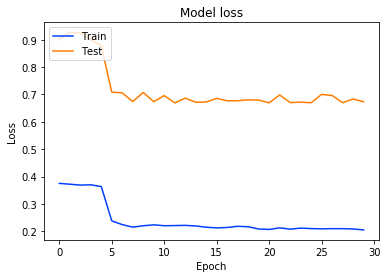

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [42]:
loss_and_metrics = model_2.evaluate(eval_data.drop('total', axis=1),
                                    eval_data['total'], 
                                    batch_size=128)
print(loss_and_metrics)
print(np.sqrt(loss_and_metrics))

212/212 [==============================] - 0s 19us/step
1.2785919190577741
1.130748388925571


# Wow!

That's a whole lot better than before.

This model also has SGD instead of rmsprop.  It would be interesting to try different models (is this still hyperparameter tuning, or something else?) and see what makes a difference.

Tried, no difference seen:

- batch size
- learning rate (without logcosh, a wildly high/low LR just took longer to converge on the exact same loss as above)

# FIXME

- There's a *lot* being done to set up the data here, and it kind of breaks the flow of the story.. I tried shortening that with loops and helper functions, but I ran into problems with columns not working the way I wanted.


- Is [MLM's "How to Convert a Time Series to a Supervised Learning Problem in Python"](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/) or ["Multivariate Time Series Forecasting with LSTMs in Keras"](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/) helpful?


- Do I need to look at normalizing the data?


- It would be interesting to see if there's a different loss function that could be aplied to the linear models -- maybe that would make a difference.


- Increasing the training epochs from 20 to 200 increased accuracy, but we got to an asymptote around 100 epochs.  I wonder if we're just overfitting at this point.


- On that note, it would be really interesting to compare this with data taken since then, or from previous years.
  - Or possibly split this up:  train on 2 months, validate on 1. 